In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq self-supervised

# SimCLR STL-10 Tutorial

**Note:** This notebook demonstrates how to use `SimCLR` callback with a single GPU. For distributed version, `DistributedSimCLR` checkout documentation.

First import **fastai** for training and other helpers, you can choose not to use **wandb** by setting `WANDB=False`.

In [1]:
from fastai.vision.all import *
torch.backends.cudnn.benchmark = True
WANDB = False
if WANDB:
    try:
        from fastai.callback.wandb import WandbCallback
        import wandb
    except:
        raise ImportError("Please run '!pip install wandb' on another cell to install wandb")

Then import **self_supervised** `augmentations` module for creating augmentations pipeline, `layers` module for creating encoder and model, and finally `simclr` for self-supervised training.

In [135]:
from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.vision.simclr import *
from self_supervised.vision.metrics import *

In this notebook we will take a look at [STL-10](https://ai.stanford.edu/~acoates/stl10/) benchmark, how to train a self-supervised model using SimCLR algorithm and then how to use this pretrained model for finetuning on the given downstream task. 

### Testing Protocol

We recommend the following standardized testing protocol for reporting results:

- Perform unsupervised training on the unlabeled.
- Perform supervised training on the labeled data using 10 (pre-defined) folds of 100 examples from the training data. The indices of the examples to be used for each fold are provided.
- Report average accuracy on the full test set.

*From stl-10 website.*

### Download and Load Data

In [3]:
from stl10 import *

sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)


In [4]:
URLs.STL_10 = "http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz"
stl10 = untar_data(URLs.STL_10)

Everything can be read to memory

In [15]:
# unsup images
unlabeled_images = read_all_images(stl10/'unlabeled_X.bin')
# train images
train_images     = read_all_images(stl10/'train_X.bin')
train_labels     = read_labels(stl10/'train_y.bin') # 1-indexed
# test images
test_images      = read_all_images(stl10/'test_X.bin')
test_labels      = read_labels(stl10/'test_y.bin') # 1-indexed
# util
class_names      = np.loadtxt(stl10/'class_names.txt', dtype=np.str_)
fold_indices     = np.loadtxt(stl10/'fold_indices.txt')

In [17]:
unlabeled_images.shape, train_images.shape, test_images.shape

((100000, 96, 96, 3), (5000, 96, 96, 3), (8000, 96, 96, 3))

### Let's check few images

#### Unlabeled

In [23]:
rand_idxs = np.random.randint(len(unlabeled_images), size=25)
random_imgs = unlabeled_images[rand_idxs]

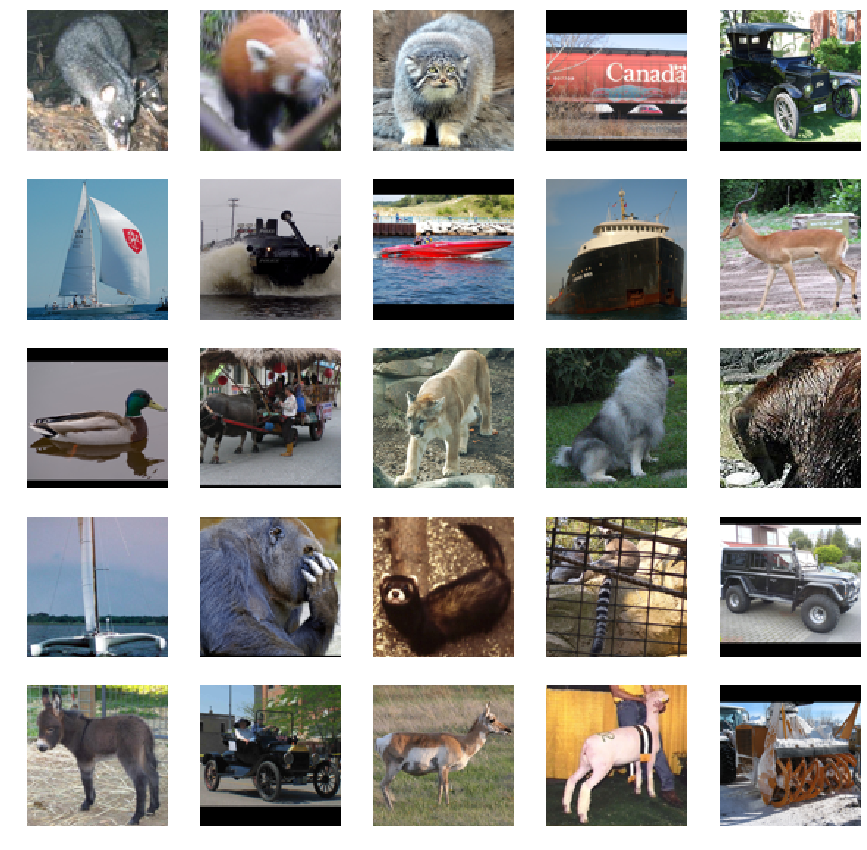

In [24]:
show_images(random_imgs, nrows=5)

### Training

In [50]:
class_names

array(['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey',
       'ship', 'truck'], dtype='<U8')

In [48]:
rand_idxs   = np.random.randint(len(train_images), size=25)
random_imgs = train_images[rand_idxs]
labels      = class_names[train_labels[rand_idxs]-1]

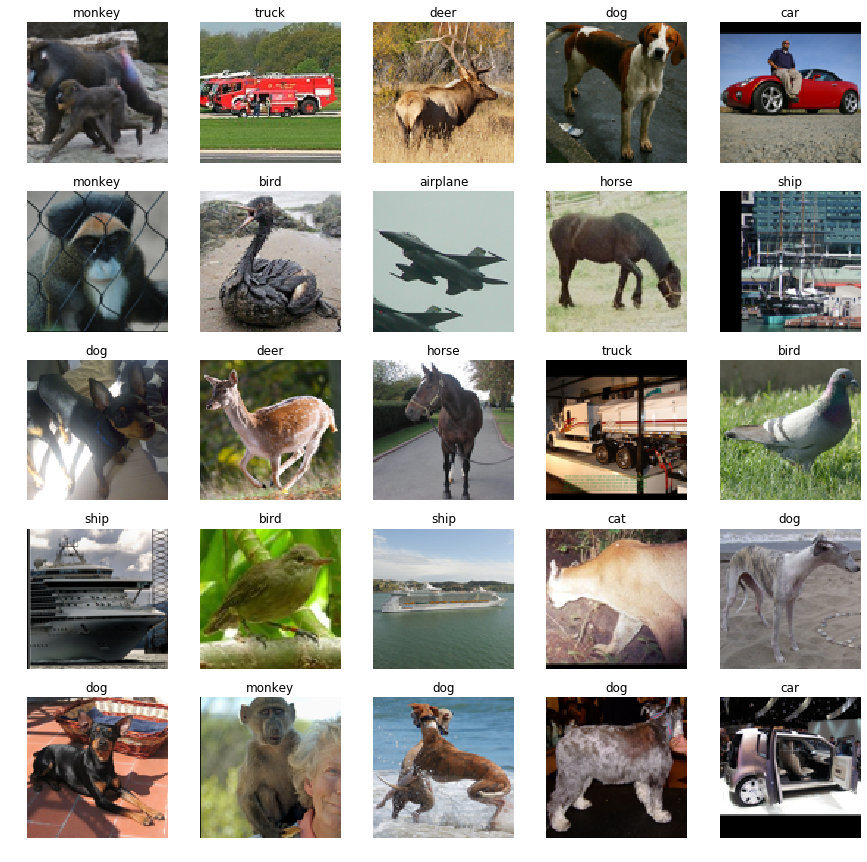

In [49]:
show_images(random_imgs, nrows=5, titles=labels)

## Pretraining

Here, we'll do self-supervised pretraining with `unlabeled + train = 100,000 + 5,000`. The reason I am including downstream training set here eventhough the number of images are only a fraction, is to use it for KNN metric tracking. This will help us to understand how good are the learned representations for the downstream task for at the end of a given epoch.

We can use 50% of train - 2,500 images as validation to track KNN Proxy Metric.

In [109]:
pretraining_images = np.vstack([unlabeled_images[:10000], train_images])

Assign dummy label -999 to unlabeled images and convert labels from 1-based to 0-based index

In [117]:
pretraining_labels = np.concatenate([np.ones(len(unlabeled_images[:10000]))*-999, train_labels-1]) 

In [118]:
pretraining_images.shape, pretraining_labels.shape, np.unique(pretraining_labels)

((15000, 96, 96, 3),
 (15000,),
 array([-999.,    0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,
           8.,    9.]))

In [119]:
labeldict = dict(enumerate(class_names)); labeldict[-999] = 'unsup'

Rest is fastai datablock api as usual

In [120]:
valid_idxs = np.random.permutation(range(len(pretraining_images)-5000, len(pretraining_images)))[:2500]

In [121]:
def get_image(idx): return pretraining_images[idx]
def get_label(idx): return labeldict[pretraining_labels[idx]]

In [122]:
# create dls
bs = 512
idxs = range(len(pretraining_images))
tfms = [[get_image, PILImage.create, ToTensor], [get_label, Categorize()]]
dsets = Datasets(idxs, tfms=tfms, n_inp=1, splits=FuncSplitter(lambda idx:True if idx in valid_idxs else False)(idxs))
batch_tfms = [IntToFloatTensor]
dls = dsets.dataloaders(bs=bs, num_workers=4, after_batch=batch_tfms)

In [123]:
len(dls.train_ds),len(dls.valid_ds)

(12500, 2500)

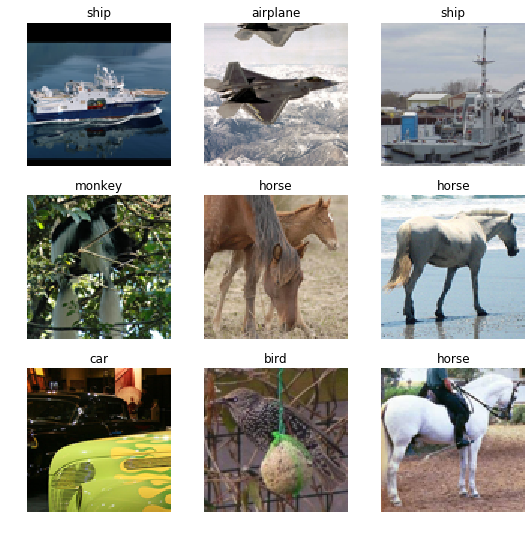

In [124]:
dls.valid.show_batch()

Select architecture to train on, remember all **timm** and **fastai** models are available! We need to set `pretrained=False` here because using STL-10 dataset has images from ImageNet.

"Images were acquired from labeled examples on ImageNet." *From STL-10 website*

In [125]:
arch = "xresnet34"
encoder = create_encoder(arch, pretrained=False, n_in=3)

In [126]:
if WANDB:
    xtra_config = {"Arch":arch, "Resize":resize, "Size":size, "Algorithm":"SWAV"}
    wandb.init(project="self-supervised-imagewang", config=xtra_config);

Initialize the Dataloaders using the function above.

Create SimCLR model. You can change values of `hidden_size`, `projection_size`, and `n_layers`. For this problem, defaults work just fine so we don't do any changes.

In [128]:
model = create_simclr_model(encoder)

In [153]:
size = 96 
aug_pipelines = get_simclr_aug_pipelines(size, 
                                         resize_scale=(0.35,1.),
                                         rotate=True,
                                         rotate_deg=20, 
                                         jitter_s=0.3,
                                         jitter=True, 
                                         bw=True,
                                         blur=False,
                                         flip_p=0.5,
                                         rotate_p=0.5,
                                         jitter_p=0.3,
                                         bw_p=0.2) 

In [154]:
aug_pipelines[0]

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}

Let's add the `SimCLR` callback for contrastive pretraining.

In [155]:
cbs = [SimCLR(aug_pipelines)]
if WANDB: cbs += [WandbCallback(log_preds=False,log_model=False)]

Then, let's also add `KNNProxyMetric` callback and define our `ValueMetric`. `KNNProxyMetric` will calculate knn@1 accuracy for validation.

In [176]:
#export
class KNNProxyMetric(Callback):
    "A metric which calculates knn-1 accuracy. Use with a labeled validation set."
    order,run_train,run_valid=8,False,True
            
    def before_batch(self):
        self.orig_x, self.orig_y = self.x, self.y
    
    def before_validate(self):
        self.embs = tensor([]).to(self.dls.device)
        self.targs = tensor([]).to(self.dls.device)
        
    def after_pred(self):
        self.embs = torch.cat([self.embs, self.model.encoder(self.orig_x)])
        self.targs = torch.cat([self.targs, self.orig_y])
  
    def accuracy(self): 
        self.embs = F.normalize(self.embs)
        sim = self.embs @ self.embs.T
        nearest_neighbor = sim.argsort(dim=1, descending=True)[:,1]
        return (self.targs == self.targs[nearest_neighbor]).float().mean()
        
    def after_fit(self):
        del self.embs, self.targs
        torch.cuda.empty_cache()

In [177]:
knn_metric_cb = KNNProxyMetric()
cbs += [knn_metric_cb]
metric = ValueMetric(knn_metric_cb.accuracy, metric_name='knn_accuracy')

In [178]:
learn = Learner(dls, model, cbs=cbs, metrics=metric)

Let's see validation score at random

In [179]:
learn.validate()

(#2) [3.107630968093872,0.33159998059272766]

Before starting training let's check whether our augmentations makes sense or not. Since this step consumes GPU memory, once you are done with inspection, restart the notebook and skip this step. We can see that 2 views of the same image side by side and indeed augmentations look pretty good. Now, it's time restart the notebook and skip this step.

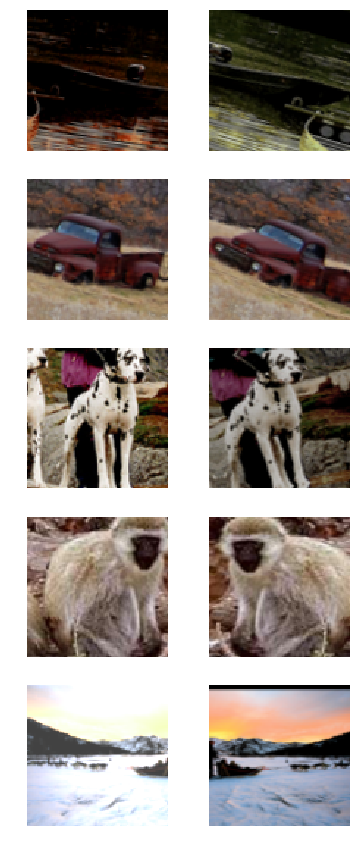

In [162]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.sim_clr.show(n=5);

Use mixed precision with `to_fp16()` for more GPU memory, larger batch size and faster training . We could also use gradient checkpointing wrapper models from `self_supervised.layers` to save even more memory, e.g. `CheckpointSequential()`.

In [163]:
learn.to_fp16();

Learning good representations via contrastive learning usually takes a lot of epochs. So here number epochs are set to 100. This might change depending on your data distribution and dataset size.

In [164]:
lr,wd,epochs=1e-2,1e-2,5

In [165]:
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5)

epoch,train_loss,valid_loss,knn_accuracy,time
0,5.739355,5.954558,0.246800,00:12
1,5.233690,4.921047,0.268800,00:08
2,4.702849,4.223056,0.273200,00:08
3,4.164154,3.483832,0.290800,00:08
4,3.886072,2.872358,0.314000,00:08


In [166]:
if WANDB: wandb.finish()

In [12]:
save_name = f'simclr_iwang_sz{size}_epc{epochs}'
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')

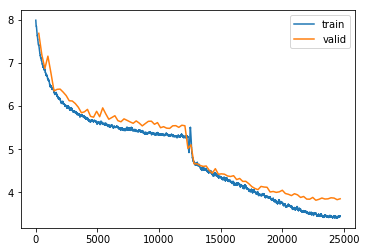

In [13]:
learn.recorder.plot_loss()

## Downstream Task

In [ ]:
optdict = dict(sqr_mom=0.99,mom=0.95,beta=0.,eps=1e-4)
opt_func = partial(ranger, **optdict)

In [ ]:
bs, size

In [ ]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    files = get_image_files(source, folders=['train', 'val'])
    splits = GrandparentSplitter(valid_name='val')(files)
    
    item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    tfms = [[PILImage.create, ToTensor, *item_aug], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=splits)
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [ ]:
def split_func(m): return L(m[0], m[1]).map(params)

def create_learner(size=size, arch='xresnet34', encoder_path="models/swav_iwang_sz128_epc100_encoder.pth"):
    
    dls = get_dls(size, bs=bs//2)
    pretrained_encoder = torch.load(encoder_path)
    encoder = create_encoder(arch, pretrained=False, n_in=3)
    encoder.load_state_dict(pretrained_encoder)
    nf = encoder(torch.randn(2,3,224,224)).size(-1)
    classifier = create_cls_module(nf, dls.c)
    model = nn.Sequential(encoder, classifier)
    learn = Learner(dls, model, opt_func=opt_func, splitter=split_func,
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
    return learn

In [ ]:
def finetune(size, epochs, arch, encoder_path, lr=1e-2, wd=1e-2):
    learn = create_learner(size, arch, encoder_path)
    learn.unfreeze()
    learn.fit_flat_cos(epochs, lr, wd=wd)
    final_acc = learn.recorder.values[-1][-2]
    return final_acc

### 5 epochs

In [ ]:
acc = []
runs = 5
for i in range(runs): acc += [finetune(size, epochs=5, arch='xresnet34', encoder_path=f'models/simclr_iwang_sz{size}_epc100_encoder.pth')]

In [ ]:
np.mean(acc)

### 20 epochs

In [ ]:
acc = []
runs = 3
for i in range(runs): acc += [finetune(size, epochs=20, arch='xresnet34', encoder_path=f'models/simclr_iwang_sz{size}_epc100_encoder.pth')]

In [ ]:
np.mean(acc)

### 80 epochs

In [ ]:
acc = []
runs = 1
for i in range(runs): acc += [finetune(size, epochs=80, arch='xresnet34',encoder_path=f'models/simclr_iwang_sz{size}_epc100_encoder.pth')]

In [ ]:
np.mean(acc)

### 200 epochs

In [ ]:
acc = []
runs = 1
for i in range(runs): acc += [finetune(size, epochs=200, arch='xresnet34', encoder_path=f'models/simclr_iwang_sz{size}_epc100_encoder.pth')]

In [ ]:
np.mean(acc)